# Chart election winner at sportsbet

## Python set-up

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import plotting

In [3]:
LFOOTER = "Betting odds observed periodically at sportsbet.com.au."
footers = plotting.footers | {"lfooter": LFOOTER}
SHOW = True

## Get data

In [4]:
FILE = "../betting-data/sportsbet-2025-election-winner.csv"
data = pd.read_csv(FILE, index_col=0, header=0, skiprows=None)
data = (
    data.pivot(columns="Party")
    .droplevel(level=0, axis=1)  # remove hierarchical column index
    .drop("Any Other Result", axis=1)  # ignore long-shot bias
    .drop("Any Other Party", axis=1)  # ignore long-shot bias
)

# convert raw text date-times to period index
data.index = pd.PeriodIndex(data.index, freq="D") 

# remove any duplicate indices and sort
data = data[~data.index.duplicated(keep="first")].sort_index() 

# fill in missing dates - this will be useful for plotting
new_index = pd.period_range(start=data.index.min(), end=data.index.max(), freq="D")
data = data.reindex(new_index, fill_value=None)

if SHOW:
    display(data.tail())

Party,Coalition,Labor
2024-11-01,NaN,NaN
2024-11-02,2.1,1.72
2024-11-03,2.1,1.72
2024-11-04,2.1,1.72
2024-11-05,2.1,1.72


## Make some charts

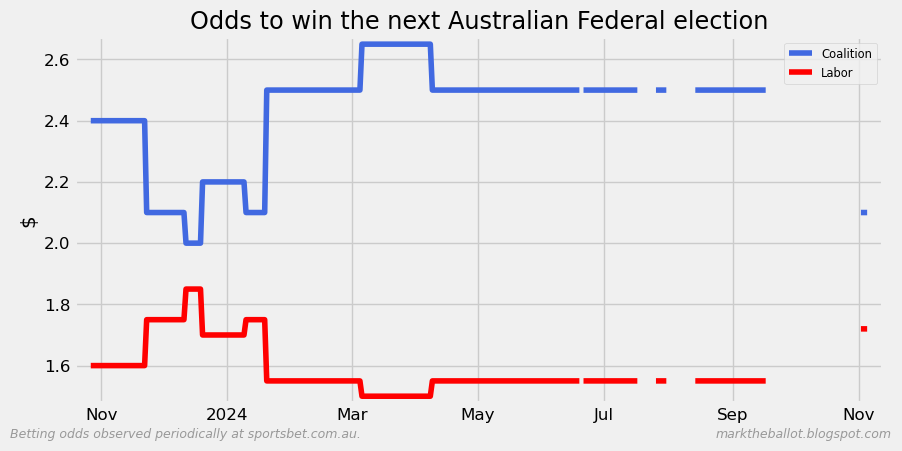

In [5]:
colors = plotting.colorise(data.columns)
ax = None
for column, color in zip(data.columns, colors):
    ax = data[column].plot.line(color=color, ax=ax)
plotting.finalise_plot(
    ax,
    title="Odds to win the next Australian Federal election",
    xlabel=None,
    ylabel="$",
    legend=plotting.LEGEND_SET,
    concise_dates=True,
    **footers,
    show=SHOW,
)

In [6]:
def convert(odds: pd.DataFrame) -> pd.DataFrame:
    # get raw probabilities
    raw_probs = 1 / odds

    # remove the bookmakers over-round
    total = raw_probs.sum(axis=1)
    adj_probs = raw_probs.div(total, axis=0)

    return adj_probs
adj_probs = convert(data) * 100

if SHOW:
    display(adj_probs.tail())

Party,Coalition,Labor
2024-11-01,NaN,NaN
2024-11-02,45.026178,54.973822
2024-11-03,45.026178,54.973822
2024-11-04,45.026178,54.973822
2024-11-05,45.026178,54.973822


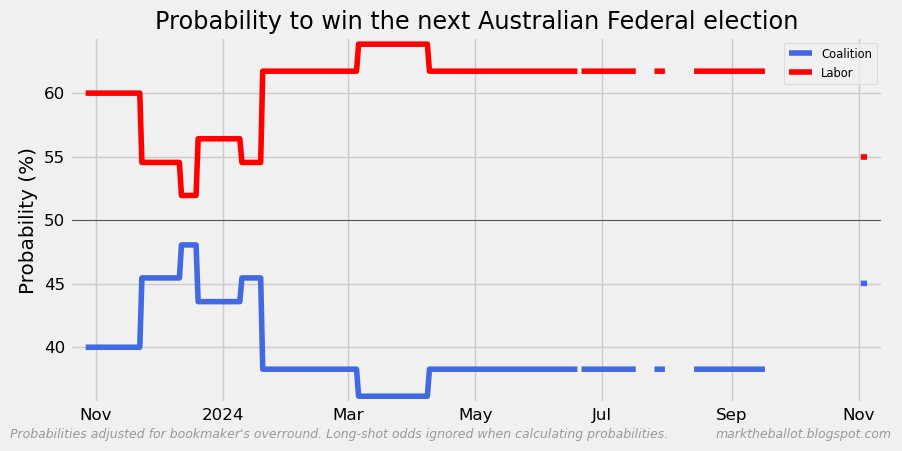

In [7]:
ax = None
for column, color in zip(adj_probs.columns, colors):
    ax = adj_probs[column].plot.line(color=color, ax=ax)

LFOOTER = (
    "Probabilities adjusted for bookmaker's overround. "
    "Long-shot odds ignored when calculating probabilities. "
)

plotting.finalise_plot(
    ax,
    title="Probability to win the next Australian Federal election",
    xlabel=None,
    ylabel="Probability (%)",
    legend=plotting.LEGEND_SET,
    concise_dates=True,
    y50=True,
    rfooter=plotting.RFOOTER,
    lfooter=LFOOTER,
    show=SHOW,
)

## Finished

In [8]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Tue Nov 05 2024 16:20:20

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

matplotlib: 3.9.2
pandas    : 2.2.3

Watermark: 2.5.0



In [9]:
print("It is done")

It is done
